# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ 

1) Which living conditions affect which life outcomes (education, health or happiness) the most?

2) What is the effect of precarious housing on health (both physical and mental) and school involvement for children?

3) Are there differences in the effects of precarious housing between both age groups considered in point **2** (children[6-11] or teenagers[12-17])? If so, for which outcomes (education, health or happiness) ?

---

   
#### NB. A brief description of all the variables (what's being measured + scales) can be found in the file `Variables_description.md`

---

## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
# Make custom palettes for seaborn
colors_light = ['#9ED9C2','#C3B8FF'] #turquoise green & blue purple
colors_dark = ['#B0D4C4','#9999FF'] #opal & lilac
customLight = sns.color_palette(colors_light)
customDark = sns.color_palette(colors_dark)

In [3]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [4]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','SEX','UAGE','STATE','UREGION','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS','CSPECED']
family = ['UFAMSTR','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS','NCPROBC','UMH2']
health = ['BDISBL','BHLTHN']
activities = ['UACT']
sec = ['UHINS4'] 

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0 or x >5) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + sec]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing/unusable values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the NLESSONS/CSPECED/BDISBL variables binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
child['CSPECED'].replace(2,0,inplace=True)
child['BDISBL'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18), UBPIB(6-18), UMH2(25-100), UACT(0-3), UAGG(4-16) &
# NCPROBC(1-3) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UMH2n'] = child['UMH2'].apply(lambda x: (x-25)/(100-25) if x != -1 else x)
child.loc[:,'UACTn'] = child['UACT'].apply(lambda x: x/3 if x != -1 else x)
child.loc[:,'UAGG'] = child['UAGG'].apply(lambda x: 16-x if x != -1 else x) #revert scale order for meaning
child.loc[:,'UAGGn'] = child['UAGG'].apply(lambda x: x/(16-4) if x != -1 else x)
child.loc[:,'NCPROBC'] = child['NCPROBC'].apply(lambda x: 3-x if x != -1 else x) #revert scale order for meaning
child.loc[:,'NCPROBCn'] = child['NCPROBC'].apply(lambda x: x/(3-1) if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,SEX,UAGE,STATE,UREGION,HHID,UENG,UENGNEG,UENGPOS,...,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NCPROBCn
0,5561612801,1,1,3,WI,2,55616128,-1,-1,-1,...,1,0.75,-1.000000,0.00,-1.0,-1.000000,0.933333,-1.000000,0.000000,-1.0
1,5470400001,2,0,14,WI,2,54704000,8,1,0,...,2,1.50,0.333333,0.00,-1.0,0.416667,0.666667,0.333333,0.000000,0.5
2,5787427204,2,1,9,WI,2,57874272,12,0,0,...,2,2.00,0.666667,0.50,1.0,-1.000000,1.000000,0.666667,0.083333,0.0
3,5410681601,1,0,4,WI,2,54106816,-1,-1,-1,...,2,2.50,-1.000000,0.25,-1.0,-1.000000,0.666667,-1.000000,0.000000,-1.0
4,5051721601,2,1,17,WI,2,50517216,13,0,0,...,2,1.25,0.750000,0.25,-1.0,0.833333,0.253333,0.333333,0.416667,0.5


In [6]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal children, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal children, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal children, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal children, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 44)
fc2: (10925, 44)
fc3:(11087, 44)
fc23: (22012, 44)
True


---

# 1) Influence of living conditions on education, health & mental health
In order to grasp which variables influence general outcome in life (education,health and happiness considered here), we are linearly regressing these outcome variables on the living conditions variables.

In [8]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [9]:
# returns a linear regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit       
    return smf.ols(formula=model, data=df_reg).fit()

## 1.1) Education: School engagement `UENG`

This indicator ranges from 4 to 16, higher scores indicating greater school engagement.

In [10]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     429.6
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:43:50   Log-Likelihood:                -48931.
No. Observations:               21087   AIC:                         9.789e+04
Df Residuals:                   21075   BIC:                         9.798e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.6909      0.161     78.606   

We can notice a few variables that have a strong impact on involvement in education (those that have a small p-value and thus a large absolute t-value):
- `SEX`: positive coefficient indicates that being a female (F=1>0=M) is strongly positively associated with involvement in school.
- `UAGG`: negative coefficient, meaning that higher parental aggravation is associated with worse school involvement.
- `UAGE`: negative coefficient, older children are negatively associated with involvement.
- `UACT`: positive coefficient, children that take part in more extracurricular activities tend to perform better at school.
- `CSPECED`: negative coefficient, ss would be expected, children with special educational needs are less involved in school.
- `UFAMSTR`: positive coefficient, school engagement increases when family structure has a higher index (**4** means living with both biological parents, **1** means living with no parents)

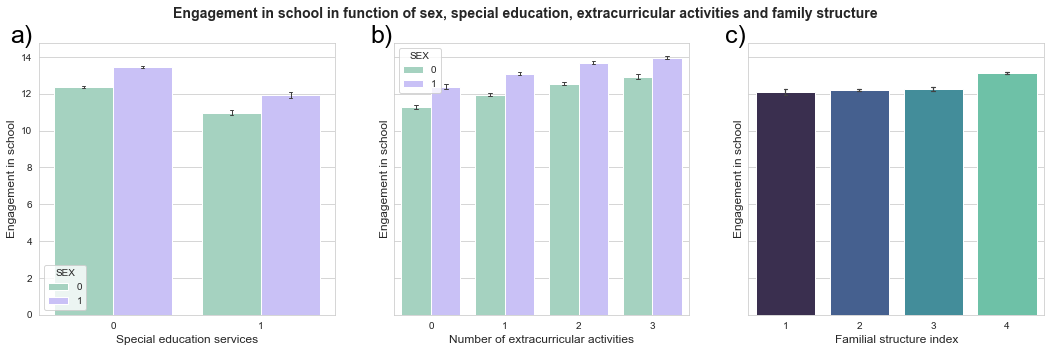

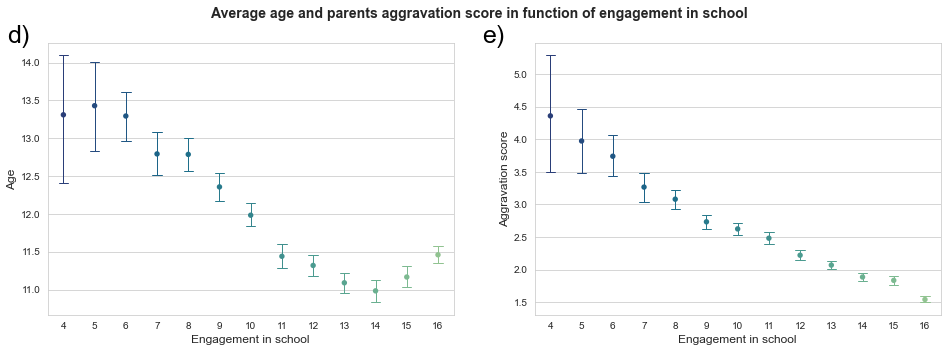

In [11]:
df = df_NN(fc23,outcome,predictors)
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
axes[2].text(-0.08,1,'c)', fontsize=25, color='k', transform=axes[2].transAxes)
sns.barplot(ax=axes[0], y='UENG', x='CSPECED', hue='SEX', palette=customLight, data=df, capsize=0.02,errwidth=1)
sns.barplot(ax=axes[1], y='UENG', x='UACT', hue='SEX', palette=customLight, data=df, capsize=0.05,errwidth=1)
sns.barplot(ax=axes[2], y='UENG', x='UFAMSTR', palette='mako', data=df, capsize=0.05, errwidth=1.2)
axes[0].set_xlabel('Special education services',fontsize=12)
axes[0].set_ylabel('Engagement in school', fontsize=12)
axes[1].set_xlabel('Number of extracurricular activities', fontsize=12)
axes[1].set_ylabel('Engagement in school', fontsize=12)
axes[2].set_xlabel('Familial structure index', fontsize=12)
axes[2].set_ylabel('Engagement in school',fontsize=12)
plt.suptitle('Engagement in school in function of sex, special education, extracurricular activities and family \
structure',fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(16,5))
axes[0].text(-0.1,1,'d)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'e)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UENG', y='UAGE', palette='crest_r', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='UENG', y='UAGG', palette='crest_r', data=df,capsize=0.3,errwidth=1,markers='.')
axes[0].set_xlabel('Engagement in school',fontsize=12)
axes[0].set_ylabel('Age', fontsize=12)
axes[1].set_xlabel('Engagement in school', fontsize=12)
axes[1].set_ylabel('Aggravation score', fontsize=12)
plt.suptitle('Average age and parents aggravation score in function of engagement in school', fontsize=14,
             fontweight='bold')
plt.show()

From plot **a)** we can see that indeed children receiving special education services show significantly less school engagement. Plot **b)** shows us that the more activities children take part in, the better their involvement with school. In these two plots, we can clearly see the impact of `SEX` on engagement: at all levels, girls are significantly more engaged than boys. 

Plot **c)** tells us the interesting effect of family structure on school involvement. Being under the supervision of two parents (index of 4) significantly improves involvement in school. On the other hand, involvement is roughly the same for children brought up with no parents, 1 parent, or in a step-family (index from 1 to 3 respectively). The latter fact is probably why `UFAMSTR` does not stand out as the most significant variable when linearly regressing it against `UENG` (compared to the other variables, with much higher t values).  

Plot **d)**  tells an interesting story.  Indeed, as a general trend, highly engaged children are younger than poorly engaged ones; we could suspect that this is correlated with the fact that with age, parents are usually less likely to be supervising their kid's school work. However, we can see that extremely engaged children (15+) comprises of older individuals ! This could be explained by the fact that a certain subpopulation of very educationally involved children tend to stay that way for their entire education, regardless of age (bringing the age mean up).

Plot **e)** shows that consistently, children with better school engagement are significantly less aggravating to their parents.
___

## 1.2) Physical health: Poor health indicator `BHLTHN`

This indicator ranges from 0: excellent health status to 5: poor health status.

In [12]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','UMH2']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     278.1
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:43:53   Log-Likelihood:                -26866.
No. Observations:               21437   AIC:                         5.376e+04
Df Residuals:                   21425   BIC:                         5.385e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5091      0.065     38.508   

We can notice a few variables that have a strong impact on bad health indicator `BHLTHN` (smallest p-values):
- `UACT`: Extracurricular activities are reducing the incidence of poor health (negative coefficient).
- `U_SOCPOV`: The richer the family, the less unhealthy the child (negative coefficient).
- `UMH2`: The better the parental mental health, the less unhealthy the child (negative coefficient).

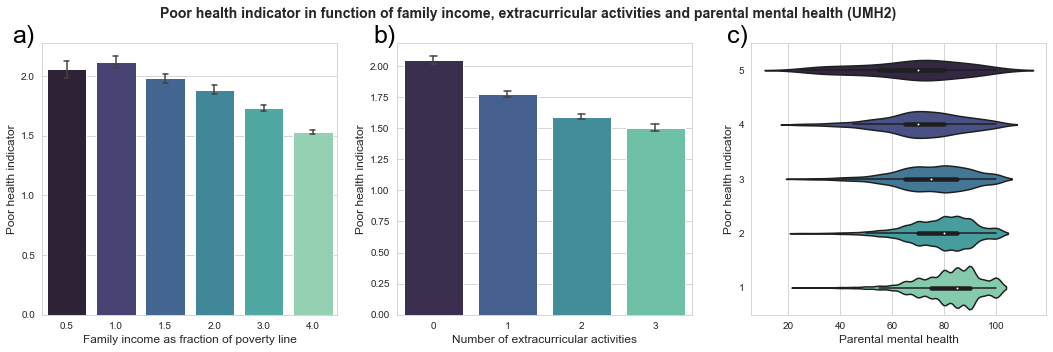

In [13]:
df = df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
axes[2].text(-0.08,1,'c)', fontsize=25, color='k', transform=axes[2].transAxes)
sns.barplot(ax=axes[0], y='BHLTHN', x='U_SOCPOV', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.barplot(ax=axes[1], y='BHLTHN', x='UACT', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.violinplot(ax=axes[2], x='UMH2', y='BHLTHN', palette='mako', data=df, orient='h',order=[5,4,3,2,1])
axes[0].set_xlabel('Family income as fraction of poverty line',fontsize=12)
axes[0].set_ylabel('Poor health indicator', fontsize=12)
axes[1].set_xlabel('Number of extracurricular activities', fontsize=12)
axes[1].set_ylabel('Poor health indicator', fontsize=12)
axes[2].set_xlabel('Parental mental health', fontsize=12)
axes[2].set_ylabel('Poor health indicator',fontsize=12)
plt.suptitle('Poor health indicator in function of family income, extracurricular activities and parental \
mental health (UMH2)', fontsize=14, fontweight='bold')
plt.show()

Plot **a)** shows that as family income rises, significantly less health issues appear. This could however be linked to a number of other covariates, such that poorer families perhaps do not have the insurance coverage to take care of their children's health issues.  

Plot **b)** indicates the significant negative relationship between extracurricular activities and health problems. It is however difficult to pinpoint the direction of causality: maybe doing less activities leads to poorer health or maybe the poor health impairs certain activities.  

Plot **c)** shows the distribution of parental mental health in function of children's health issues. We can see that as children health gets worse, so does the mental health of the parents. This makes sense to us, as the health of their child should definitely have an impact on the mental well-being of the parents.

___

## 1.3) Mental health

### 1.3.1) Child mental health `NCPROBC`

This indicator answers to the question whether child has been sad or depressed in the past month, ranging from 1 to 3, lower scores indicating better mental health (less depressive feeling).

In [14]:
outcome = 'NCPROBC'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','UMH2']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                NCPROBC   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     378.1
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:43:55   Log-Likelihood:                -15884.
No. Observations:               21382   AIC:                         3.179e+04
Df Residuals:                   21370   BIC:                         3.189e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9095      0.039     23.214   

We can notice a few variables that have a strong impact on child depression/sadness index `NCPROBC` (smallest p-values):
- `UAGE`: Mental health of children gets poorer with age (positive coefficient).
- `UFAMSTR`: The better the family structure, the better the child's mental health (negative coefficient).
- `UAGG`: Parental aggravation is positively correlated with child depression (positive coefficient).
- `UMH2`: The better the parental mental health, the better the child's (negative coefficient).

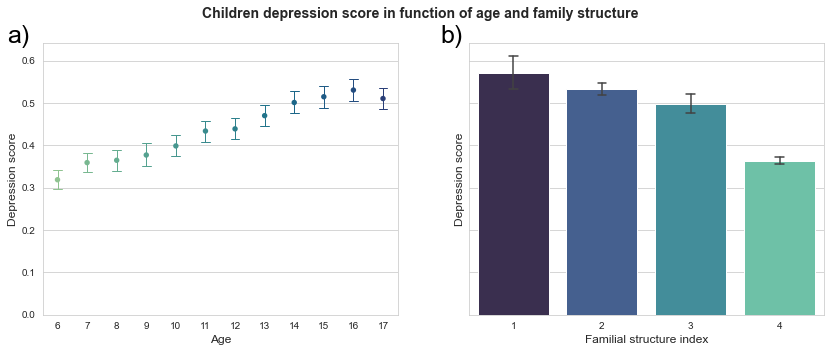

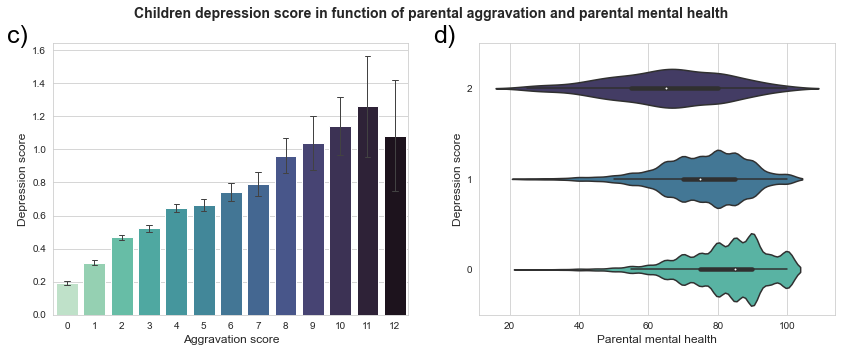

In [15]:
df=df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGE', y='NCPROBC', palette='crest', data=df,capsize=0.3,errwidth=1,markers='.')
sns.barplot(ax=axes[1], y='NCPROBC', x='UFAMSTR', palette='mako', data=df,capsize=0.1,errwidth=1.5)
axes[0].set_xlabel('Age',fontsize=12)
axes[0].set_ylabel('Depression score', fontsize=12)
axes[1].set_xlabel('Familial structure index', fontsize=12)
axes[1].set_ylabel('Depression score', fontsize=12)
plt.suptitle('Children depression score in function of age and family structure', fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].text(-0.13,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.barplot(ax=axes[0], x='UAGG', y='NCPROBC', palette='mako_r', data=df,capsize=0.2,errwidth=1)
sns.violinplot(ax=axes[1], x='UMH2', y='NCPROBC', palette='mako', data=df, orient='h',order=[2,1,0])
axes[0].set_xlabel('Aggravation score',fontsize=12)
axes[0].set_ylabel('Depression score', fontsize=12)
axes[1].set_xlabel('Parental mental health', fontsize=12)
axes[1].set_ylabel('Depression score', fontsize=12)
plt.suptitle('Children depression score in function of parental aggravation and parental mental health',
             fontsize=14, fontweight='bold')
plt.show()

Plot **a)** describes the effect of age on mental health that was discovered with the regression: mental health of children gets poorer with age. The trend seems to be reaching a plateau at 16, which coincides with the end of adolescence. Adolescence is indeed, for a lot of children, a very difficult and troubling period, which might explain this upward trend of depression with age (10 to 16).  

Plot **b)** depicts the relationship between family structure and child mental health: as the structure gets better, the depression score plummets.  

Plot **c)** unequivocally shows the positive relationship between parental aggravation score and children depression index. Once again, the causal link between the two variables is very difficult to establish.  

Plot **d)** shows the distribution of parental mental health scores depending on the child's mental state. We can definitely see the positive correlation between parent and child's mental healths. It is however difficult to say whether this correlation is due to a common covariate (bad housing conditions for example) which impacts the mental health of the entire household, or if one's mental health impacts that of others in the household.

### 1.3.2) Parents' mental health `UMH2`

This meantal health scale ranges from 25 to 100, higher scores indicating better mental health.

In [16]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh+['SEX','BDISBL','UAGG']
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     642.0
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:43:58   Log-Likelihood:            -1.3095e+05
No. Observations:               33466   AIC:                         2.619e+05
Df Residuals:                   33455   BIC:                         2.620e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       77.4133      0.610    126.830   

We can notice a few variables that have a strong impact on parental mental health `UMH2` (smallest p-values):
- `U_SOCPOV`: The wealthier, the better the mental health (positive coefficient).
- `BDISBL`: The mental health of the parents is worse when the child has a disability (negative coefficient).
- `UAGG`: As expected, the more aggravating a child is, the worse the parent's mental health (negative coefficient). 

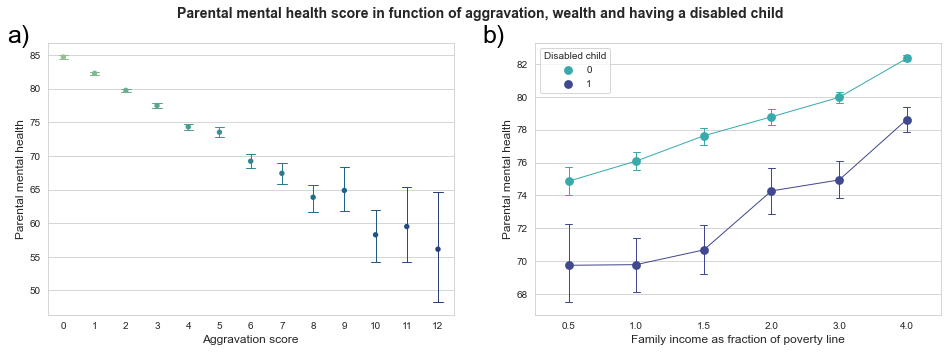

In [17]:
df = df_NN(child,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(16,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGG', y='UMH2', palette='crest', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='U_SOCPOV', y='UMH2', hue='BDISBL', palette='mako_r', data=df, capsize=0.1, errwidth=1)
plt.legend(title='Disabled child')
axes[0].set_xlabel('Aggravation score',fontsize=12)
axes[0].set_ylabel('Parental mental health', fontsize=12)
axes[1].set_xlabel('Family income as fraction of poverty line', fontsize=12)
axes[1].set_ylabel('Parental mental health', fontsize=12)
for l in axes[1].lines:
    plt.setp(l,linewidth=1)
plt.suptitle('Parental mental health score in function of aggravation, wealth and having a disabled child',
             fontsize=14,fontweight='bold')
plt.show()

Plot **a)** depicts the negative correlation between parental mental health and aggravation. The more aggravated the parents are with the child, the worse is their mental health. The causal link however is hard to establish. 

Plot **b)** shows the effect of both income and having a disabled child on mental health. Regardless of disability, higher income leads to significantly better mental health. So, can _money buy happiness?_ It is difficult to say, as there are a large number of covariates linked to income that could impact mental health that we did not account for in this graph.   
We can also see that, indeed, having a child with a disability is linked with poorer parental mental health (looks like about a 10% discrepency with the control group in light blue). We can conclude that raising a disabled kid takes a negative toll on the mental health of the parents.

---

# 2) Impact of precarious living conditions on children's education, physical & mental health 

We first have to define what a precarious environment is. For this, we establish a new variable called `living_ind` which gives a score reflective of the quality of life. We use the number of people per bedroom `OVERCROWDING`, family structure `UFAMSTR`, household ownership `MOWNRENT`, parental aggravation score `UAGG`, health insurance `UHINS4` and household income `U_SOCPOV` to define and quantify our index.  

Looking at the distribution of living indices [`living_ind`.describe()], we then decide on a threshold that indicates that any household with a value under said threshold is considered precarious. We establish a boolean `precarious` variable that is **1** if the household is precarious and **0** if not.  

N.B. Our threshold is 0: a negative `living_ind` indicates precarity and a positive one does not.

In [18]:
# Variables used for precarity indicator (economics and relationship with family)
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']
df_prec = df_NN(fc23,'PERSID',prec)

In [19]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them 
# N.B. performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
norm_prec.loc[:,negative] *= -1

# Add custom weights for different variables
weights = [2.5,7,0.5,0.5,0.25,2]

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.dot(weights)

# Choose a threshold to consider a household 'precarious' or not (we chose the value 0)
threshold = 0
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < threshold else 0)

print(norm_prec['living_ind'].describe())

count    21515.000000
mean         1.371713
std          1.704213
min         -7.708333
25%          0.214286
50%          1.691964
75%          2.847222
max          4.187500
Name: living_ind, dtype: float64


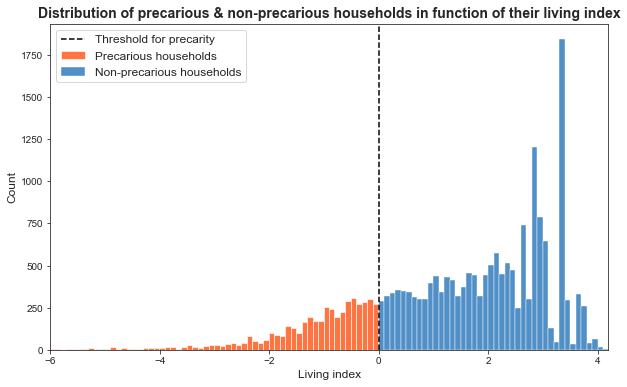

In [20]:
sns.set_style('ticks')
fig, axes = plt.subplots(1,figsize=(10,6))
sns.histplot(ax=axes, data = norm_prec[norm_prec['precarious']==1]['living_ind'], binwidth=0.1,color='orangered')
sns.histplot(ax=axes, data = norm_prec[norm_prec['precarious']==0]['living_ind'], binwidth=0.1, color='#176BB5')
plt.axvline(threshold,color='k',linestyle='--')
axes.set_xlabel('Living index',fontsize=12)
axes.set_ylabel('Count', fontsize=12)
plt.xlim(-6,4.2)
plt.legend(['Threshold for precarity','Precarious households','Non-precarious households'],fontsize=12)
plt.title('Distribution of precarious & non-precarious households in function of their living index',
         fontsize=14,fontweight='bold')
plt.show()

Looking at the `living_ind` description, we can infer that less than 25% of surveyed children live under precarious conditions (as the 25% quantile is slightly over the threshold of 0).  
Let's add the `precarious` boolean to our dataframe containing children aged 6-17:

In [21]:
# Add precarious indicator to dataframe
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')

We would now like to highlight the effect of living in a `precarious` household on education, physical and mental health. We could simply graph the different outcomes with respect to the `precarious` binary hue, but this would not account for the different covariates (such as parental educational degree, sex and age) that will without a doubt have significant interaction coefficients.

We therefore decided to implement a __**Propensity Score Matching (PSM)**__. For this, we first assign a propensity score (PS) to each subject, which represents the likelihood to be in a precarious household, based on covariates information. Then, we match subjects who had similar propensity scores but still ended up in the two different subpopulations (precarious and not). This creates 2 subsets of individuals which have extremely similar distributions of the covariates but are still divided based on the precarity 'treatment', which allows us to quantify the effect of the latter.

## 2.1) Propensity score establishment

Let's first make an example of PSM using the treatment variable `bool0_5`, which shows whether or not a household has a young child aged between 0 and 5. we would like to highlight the effects of having young children in the household.  

### **PS with `bool0_5` as treatment**
We first need to establish a logistic regression of `bool0_5` on the covariates, which we train using the entire available dataset.

In [22]:
# logistic regression for bool0_5
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT',
             'OVERCROWDING','BDISBL','UHINS4','NCPROBC']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ C(SEX) + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + UHHCOUNT + U_SOCPOV + MNBEDRMS + \
MOWNRENT + OVERCROWDING + C(BDISBL) + UHINS4 + NCPROBC'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.497028
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21388
Model:                          Logit   Df Residuals:                    21371
Method:                           MLE   Df Model:                           16
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.1653
Time:                        03:44:01   Log-Likelihood:                -10630.
converged:                       True   LL-Null:                       -12735.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.0951      0.214    -19.155      0.000      -4.514      -3.676
C(SEX)[T.1]        0.0014      0.034      0.041      0.967      -0.066       0.068
UREGION[T.2]      -0.0138      0.049     -0.282      0.778      -0.110       0.082
UREGION[T.3]       0.0233      0.050      0.469      0.639      -0.074       0.121
UREGION[T.4]       0.0010      0.051      0.020      0.984      -0.099       0.101
C(BDISBL)[T.1]    -0.2739      0.054     -5.031      0.000      -0.381      -0.167
UFAMSTR           -0.0123      0.020     -0.621      0.535      -0.051       0.027
UMH2               0.0066      0.001      4.648      0.000       0.004       0.009
UMHIGDEG          -0.0239      0.009     -2.617      0.009      -0.042      -0.006
UAGG               0.0291      0.010      2.928      0.003       0.010       0.049
UHHCOUNT           0.7226      0.029     24.551      0.000       0.665       0.780
U_SOCPOV          -0.2050      0.018    -11.651      0.000      -0.239      -0.170
MNBEDRMS          -0.1381      0.042     -3.315      0.001      -0.220      -0.056
MOWNRENT           0.2268      0.039      5.863      0.000       0.151       0.303
OVERCROWDING       0.3144      0.073      4.280      0.000       0.170       0.458
UHINS4            -0.0901      0.020     -4.446      0.000      -0.130      -0.050
NCPROBC            0.0137      0.034      0.406      0.685      -0.052       0.080
==================================================================================
"""

We can now assign a number to each individual, by evaluating the logistic regression with their covariates, which yields a number in the interval [0;1], the propensity score. The testing set is precisely the training set.

In [23]:
# from the logistic regression, compute the predicted propensity from the training set
pred05 = res1.predict(df_05)
df_05.loc[:,'PS'] = pred05

//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## 2.2) Matching
We now need to perform 1-to-1 matching of individuals between the treated and control subpopulations with similar PS. For this, we use our implemented `optimatch` method which, for each treated individual, finds the individual from the control set with the closest PS (`find_nearest` method) and matches them together if and only if the difference in PS is smaller than a certain threshold value $\epsilon$ (we will use 0.01 by default, which is quite a low threshold and will thus yield very strict matchings).   

`plotPS` is a method that takes care of the matching and additionnally graphs:
- the propensity score distributions of the two subpopulations (control and treatment) before and after matching,
- the distribution of a variable of choice, inputted as `var` in the method. By choosing a covariate (used in the PS) as the plotted `var`, we can visualize the distribution of said covariate pre- and post-matching.

#### Useful methods

In [24]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [25]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally matched
# propensity scores
def optimatch(ctrl_df,trtm_df,epsilon=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): #iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < epsilon):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

In [26]:
# plots the matched vs unmatched repartition of 1) Propensity score and 2) a random variable var,
# option to return the matched dataframe
def plotPS(unmatched,treatment,var,ret=False):
    
    treated = unmatched[unmatched[treatment]==1].sample(frac=1).reset_index(drop=True)
    control = unmatched[unmatched[treatment]==0].sample(frac=1).reset_index(drop=True)
    
    matched = optimatch(treated,control,0.001)
    
    # the sizes can tell us how many individuals the epsilon threshold weeds out
    print(f'Number of treated subjects : {treated.shape[0]} \n\
Number of control subjects : {control.shape[0]} \n\
Number of matched pairs : {matched[matched[treatment]==1].shape[0]}')
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.histplot(ax = axes[0], data=unmatched, x="PS", hue=treatment, kde=True, element='step', stat='density',
                 common_norm=False, palette= customDark)
    sns.histplot(ax = axes[1], data=matched, x="PS", hue=treatment, kde=True, element='step', stat='density',
                 common_norm=False, palette = customDark)
    axes[0].set_title('Pre-matching',fontsize=14)
    axes[1].set_title('Post-matching', fontsize=14)
    plt.suptitle('Propensity score distribution for unmatched and matched samples', fontsize=15, fontweight='bold')
    plt.show()
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.kdeplot(ax=axes[0], data=unmatched, x=var, hue=treatment, palette=customDark, shade=True, common_norm=False)
    sns.kdeplot(ax=axes[1], data=matched, x=var, hue=treatment, palette=customDark, shade=True)
    axes[0].set_title('Pre-matching',fontsize=14)
    axes[1].set_title('Post-matching', fontsize=14)
    axes[0].set_xlim(0,5)
    axes[1].set_xlim(0,5)
    plt.suptitle(var+' distribution for unmatched and matched samples', fontsize=15, fontweight='bold')
    plt.show()
    
    if(ret):
        return matched

---

Number of treated subjects : 6045 
Number of control subjects : 15343 
Number of matched pairs : 5153


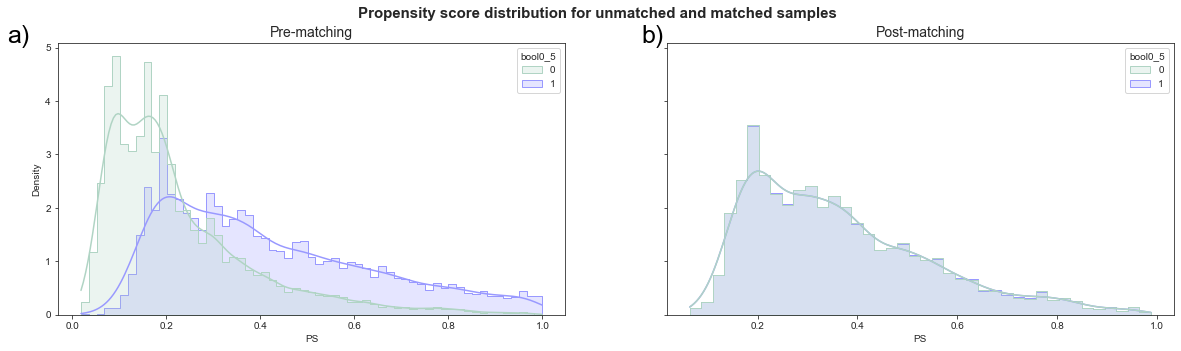

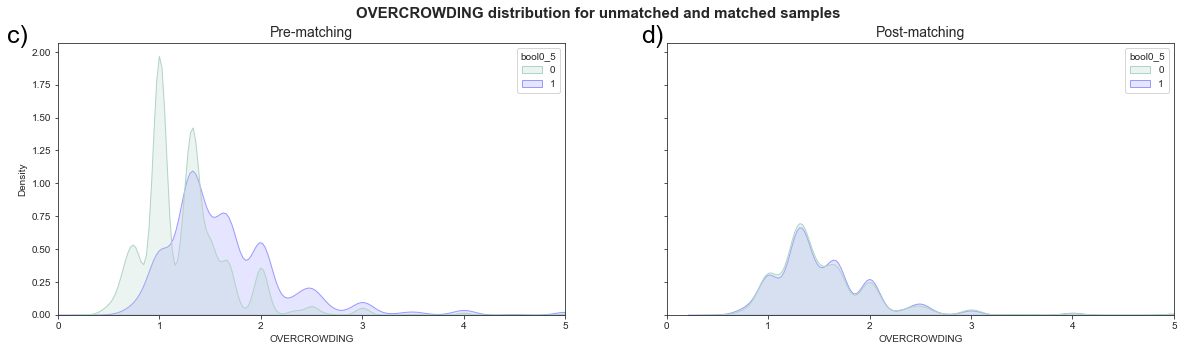

In [27]:
plotPS(df_05,'bool0_5','OVERCROWDING')

First of all, we can see that the matching method returns about 5'000 matched pairs (from an initial treatment set of $\approx$ 6'000), meaning we lose about a sixth of the treated subjects in the process. We believe this to be a good result considering the tightness of the $\epsilon$ threshold we chose (0.01). 

Looking at graphs **a)** and **b)**, which represent the PS distributions pre- and post-matching respectively, we notice that indeed, the matching selects for individual pairs with extremely similar propensity scores. The two populations (treatment and control) are effectively undistinguishable on plot **b)**, which is again a testimony to the small $\epsilon$ coefficient.

Looking at plots **c)** and **d)**, which represent the covariate (`OVERCROWDING`) distributions pre- and post-matching respectively, we notice that indeed, the matching selects for individual pairs with extremely similar covariate values. We can notice that pre-matching, the treated population (with young children, in green) has on average a higher `OVERCROWDING` value. This is intuitive as our treatment choice involved the presence of at least one child, meaning that in the absence of other information, it is safe to assume that households with additional people (treatment) can only be more overcrowded than their control counterpart.  
Plot **d)** shows the extreme homogeneity of the covariate post-matching.



### PS with `precarious` as treatment
Let us now repeat the same process with the `precarious` treatment this time. The covariates include (non-exhaustively) age `UAGE`, sex `SEX`, geographical region `UREGION`, overcrowding `OVERCROWDING`, the number of activities the child takes part in `UACT`...

In [28]:
# logistic regression for precarious

predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS','OVERCROWDING','BDISBL','CSPECED','UACT']
df_prec_raw = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ C(SEX) + UAGE + UREGION + UMHIGDEG + UHHCOUNT + MNBEDRMS + OVERCROWDING + \
C(BDISBL) + CSPECED + UACT'

log_prec = smf.logit(formula=log_model_prec, data=df_prec_raw)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.385589
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21317
Model:                          Logit   Df Residuals:                    21304
Method:                           MLE   Df Model:                           12
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.2657
Time:                        03:44:14   Log-Likelihood:                -8219.6
converged:                       True   LL-Null:                       -11194.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3223      0.270     -4.900      0.000      -1.851      -0.793
C(SEX)[T.1]        0.1324      0.040      3.330      0.001       0.054       0.210
UREGION[T.2]      -0.2333      0.060     -3.910      0.000      -0.350      -0.116
UREGION[T.3]       0.4243      0.056      7.607      0.000       0.315       0.534
UREGION[T.4]       0.0734      0.060      1.226      0.220      -0.044       0.191
C(BDISBL)[T.1]     0.3663      0.066      5.591      0.000       0.238       0.495
UAGE               0.0121      0.006      2.139      0.032       0.001       0.023
UMHIGDEG           0.0168      0.010      1.643      0.100      -0.003       0.037
UHHCOUNT           0.1807      0.053      3.419      0.001       0.077       0.284
MNBEDRMS          -0.8585      0.085    -10.143      0.000      -1.024      -0.693
OVERCROWDING       1.3963      0.150      9.331      0.000       1.103       1.690
CSPECED            0.2227      0.066      3.383      0.001       0.094       0.352
UACT              -0.4732      0.022    -21.590      0.000      -0.516      -0.430
==================================================================================
"""

In [29]:
pred_prec = res_prec.predict(df_prec_raw.copy())
df_prec_raw.loc[:,'PS'] = pred_prec

//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 4660 
Number of control subjects : 16657 
Number of matched pairs : 3475


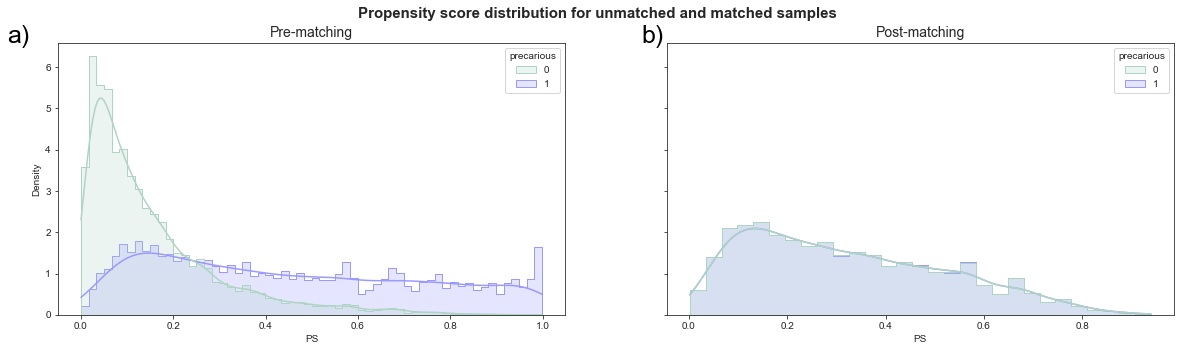

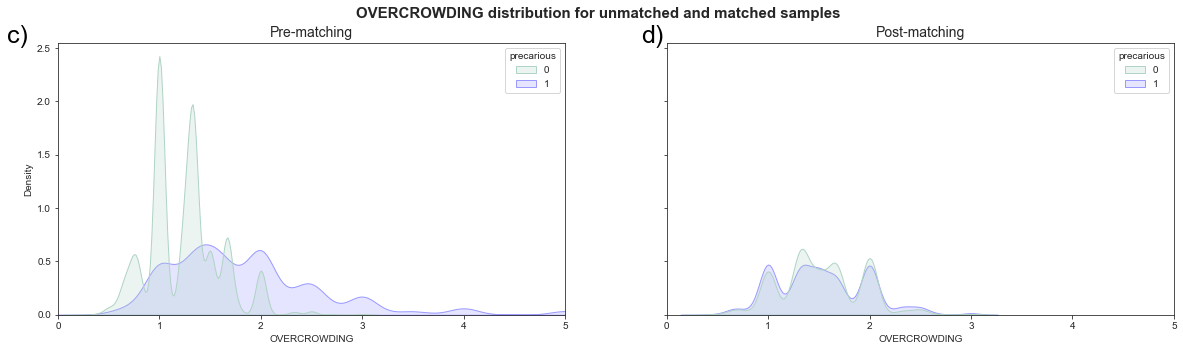

In [30]:
df_prec = plotPS(df_prec_raw,'precarious','OVERCROWDING',True)

The same conclusions can be drawn as previously with the `bool0_5` treatment - matching is sucessful and we can now look at the treatment effects.

## 2.3) Average treatment effect
By looking at the difference of a certain variable $y$ in control and treatment groups, we can calculate the Average Treatment Effect (ATE) as 
$$ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{ctrl}^{(i)}$$  
$$\overline{ATE}= \bar{y}_{treat} - \bar{y}_{ctrl}$$  
We must be careful of choosing variables which are not used in the PS (otherwise the ATE will be zero).  

The reason we performed PSM in the first place was to get an accurate ATE for the `precarious` treatment alone, not an ATE that has the influence of covariates, and thus would not be very representative. Let's graphically and numerically check that indeed the ATEs calculated pre- and post-matching are different:

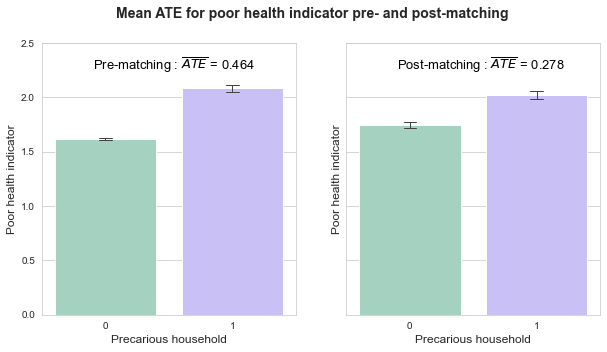

In [31]:
# Compute ATE for health variable
var='BHLTHN'
means_prec_raw = df_prec_raw.groupby('precarious').mean()
means_prec = df_prec.groupby('precarious').mean()

with sns.axes_style("whitegrid"):
    pre = str(round(means_prec_raw[var][1] - means_prec_raw[var][0],3))
    post = str(round(means_prec[var][1] - means_prec[var][0],3))
    title0 = 'Pre-matching : $\overline{ATE}$ = ' + pre
    title1 = 'Post-matching : $\overline{ATE}$ = ' + post
    fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
    axes[0].text(0.2,0.9,'Pre-matching : $\overline{ATE}$ = ' + pre, fontsize=13, color='k', transform=axes[0].transAxes)
    axes[1].text(0.2,0.9,'Post-matching : $\overline{ATE}$ = ' + post, fontsize=13, color='k', transform=axes[1].transAxes)
    sns.barplot(ax = axes[0], data=df_prec_raw,x='precarious',y=var, palette=customLight,capsize=0.1,errwidth=1)
    sns.barplot(ax = axes[1], data=df_prec,x='precarious',y=var, palette=customLight,capsize=0.1,errwidth=1)
    axes[0].set_ylim(0,2.5)
    axes[1].set_ylim(0,2.5)
    axes[0].set_xlabel('Precarious household', fontsize=12)
    axes[0].set_ylabel('Poor health indicator', fontsize=12)
    axes[1].set_xlabel('Precarious household', fontsize=12)
    axes[1].set_ylabel('Poor health indicator', fontsize=12)
    plt.suptitle('Mean ATE for poor health indicator pre- and post-matching', fontsize=14, fontweight='bold')

We can indeed see from the plot above that PSM changes the ATE compared to the unmatched data. This is explained by the fact that the model on the left (pre-matching) still has the influence of all the covariates __*__ associated with the `precarious` treatment. We can thus conclude that the matching has the desired effect on the ATEs we wish to measure.  

__*__ As the ATE is lowered by the matching, we can assume that most `precarious`-covariates have a positive correlation with the chosen variable `BHLTHN`, which overinflates the raw ATE, misleading uncareful observers at first glance. This is a common statistical fallacy used to manipulate results and especially conclusions.

We now want to compare the ATEs of `precarious` for different variables. Unfortunately, ATEs are still in the unit of the $y$ variable, meaning it is not comparable with other ATEs.  
One way to circumvent that issue is to normalize the variables $y$ into $y_n$ $\in [0;1]$. This way, the ATE is expressed as a percentage change and is thus unitless and can be compared with limitless other variables of interest $y_n$. Let's try to plot mutliple ATEs on the same graph to recapitulate the different effects:

## 2.4) Effects of precarity on education, health & happiness

We designed a method `ATE_sch_hlth_happ` that returns a dataframe containing:

- the normalized variables of interest (can be manually imputed). We are using an education variable (`UENGn`), a health variable (`BHLTHNn`), several mental health variables (child: `NCPROBCn`, `UBPIAn`, `UBPIBn`, parent: `UMH2n` and `UAGGn`) and a control variable (`UACTn`__*__) 

- the respective means of the normalized $ATE$,  $\overline{ATE}$

- 3 confidence intervals for $ATE$ (90%, 95% and 99%)   

Reminder of the CI for the difference between two means (here sample sizes $n_1 = n_2 = n $ as the individuals are matched one-to-one):
$$CI_{\alpha} : (\overline{x_1}-\overline{x_2})\pm Z_{\alpha/2}\cdot SE,$$

$$SE=\sqrt{\frac{s_1^2+s_2^2}{n}}$$  
        
        
- the significance (is the $ATE$ significantly different from $0$), illustrated by stars (`***`=1%, `**`=5%, `*`=10% or `Not significant`). An $ATE$ is significant at level $\alpha \iff$ the value $0$ is not contained in its $(1-\alpha)\%$ confidence interval.

We then use the method `plot_ATE` to plot the 95% CI of all the ATEs, coloring them in:
- blue if ATE is positively significant
- orange if ATE is negatively significant
- gray if ATE is not significant at the 5% level


__*__`UACT` was one of the covariates used in the making of the `precarious` PS. It should thus be evenly distributed by the matching and we expect it to have an ATE close to $0$.

#### Useful methods

In [32]:
# Computes CI at level alpha of a difference between two sets
def CI(alpha, val1, val0, mean):    
    z = st.norm.ppf(1-alpha/2)
    n = val1.size
    s1 = np.std(val1)
    s2 = np.std(val0)
    se= np.sqrt((s1*s1 + s2*s2)/n)
    return (mean-z*se,mean+z*se)

In [33]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return ''

In [34]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    val_1 = df_match.loc[df_match[treatment_var]==1,voi].values
    val_0 = df_match.loc[df_match[treatment_var]==0,voi].values
    pairs_difference = val_1 - val_0
    sd = np.std(pairs_difference)
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, val_1, val_0, ate), CI(0.05, val_1, val_0,ate), CI(0.01, val_1, val_0, ate)]
    star = stars(ci)
    
    return ate, ci, star, df_match.shape[0], sd

In [35]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    sizes = []
    sds = []
    
    for var in list_voi:
        print(var)
        ate, ci, star, size, sd = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        sizes.append(size)
        sds.append(sd)
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99,
                           'Significance': stars, 'Sample size':sizes, 'Std. Dev':sds})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [36]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var, interest_var, fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, interest_var)
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [37]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3,
                     elinewidth=0.75,label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('nATE (with 95% CI)', fontsize=12)
    plt.xlim(-0.1,0.1)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Normalized average treatment effect (nATE) of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [38]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['orangered', 'lightsteelblue', 'royalblue'])

---

Let's graph these precarity ATEs:

In [39]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'])
ate_precarious[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 6768 / 6873
BHLTHNn
Number of matched subjects: 6866 / 6950
UMH2n
Number of matched subjects: 6860 / 6939
UACTn
Number of matched subjects: 6884 / 6950
UAGGn
Number of matched subjects: 6878 / 6950
NCPROBCn
Number of matched subjects: 6826 / 6924
UBPIAn
Number of matched subjects: 3170 / 3632
UBPIBn
Number of matched subjects: 2876 / 3282


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,6768,-0.036520,[-0.045804 ; -0.027236],[-0.047582 ; -0.025458],[-0.051058 ; -0.021982],***
1,BHLTHNn,6866,0.062263,[0.052768 ; 0.071758],[0.050949 ; 0.073577],[0.047394 ; 0.077132],***
2,UMH2n,6860,-0.058970,[-0.066757 ; -0.051183],[-0.068249 ; -0.049691],[-0.071165 ; -0.046775],***
3,UACTn,6884,0.003971,[-0.007894 ; 0.015835],[-0.010167 ; 0.018108],[-0.014609 ; 0.022550],
4,UAGGn,6878,0.035790,[0.028950 ; 0.042631],[0.027640 ; 0.043941],[0.025079 ; 0.046502],***
5,NCPROBCn,6826,0.034134,[0.022651 ; 0.045617],[0.020451 ; 0.047817],[0.016152 ; 0.052117],***
6,UBPIAn,3170,-0.035542,[-0.046412 ; -0.024671],[-0.048494 ; -0.022589],[-0.052564 ; -0.018519],***
7,UBPIBn,2876,-0.023934,[-0.035565 ; -0.012303],[-0.037793 ; -0.010075],[-0.042148 ; -0.005720],***


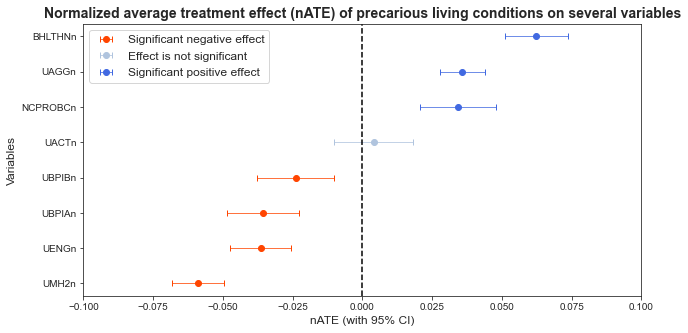

In [40]:
plot_ATE(ate_precarious,'precarious')

We can look at each individual variable and make comments on its ATE:
- `BHLTHNn` (poor health indicator) has a relatively large significantly positive ATE. This means that living in a precarious household is positively associated with the poor health of children.

- `NCPROBCn` (children depression score) has a relatively large significantly positive ATE. This indicates that living in a precarious household is positively associated with higher depressive feelings in children.
- `UAGGn` (parental aggravation score) has a positive and significant ATE: this indicates that parents are generally more aggravated with their children if the household is precarious.
- `UBPIBn` and `UBPIAn` (children behavior score, higher scores indicates better behavior) both exhibit a negative ATE. This means that precarity enhances the probability of having behavioral issues. However, we can notice that the ATE of `UBPIAn` (6-11 y.o.) is more pronounced than that of `UBPIBn` (12-17 y.o.). This gives us a hint that perhaps the ATEs of the subpopulations of children (segregation based on age range) are not exactly similar (_this is in fact the motivation for our third main aim_).
- `UENGn` (engagement in school) exhibits a negative ATE: school engagement is generally lower for children from precarious households.
- `UMH2` (parental mental health) has a relatively large significantly negative ATE. This means that parents in precarious households tend to have worse mental health. We can compare with the ATE of `NCPROBCn` (which is also a mental health index, but for children) and conclude: as the absolute value of the average treatment effect $\mid$$ATE\mid$__*__ is larger for parents, we can infer that adults are more impacted than children by precarious housing. This could be due to the financial and administrative aspect that children are usually not subjected to.
- As expected, the control covariate included in the propensity score (`UACTn`) does not show any significant ATE, as this variable is supposedly matched equally between the two populations.  

__*__ we consider the absolute value because, while being two mental health indices, `NCPROBCn` and `UMH2n` do not follow the same scaling system (**1** means good mental health in `UMH2n`, but bad in `NCPROBCn`).

# 3) Differential impact of precarity on children (6-11 y.o.) vs. teenagers (12-17 y.o.)

Let's segregate the previous population into two subpopulations and compute the multiple ATEs for each of them (children vs. teenagers)

In [41]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',
                                       ['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'],fc2=True)
ate_precarious_fc2[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 3142 / 3622
BHLTHNn
Number of matched subjects: 3186 / 3649
UMH2n
Number of matched subjects: 3188 / 3645
UACTn
Number of matched subjects: 3198 / 3649
UAGGn
Number of matched subjects: 3188 / 3649
NCPROBCn
Number of matched subjects: 3166 / 3638
UBPIAn
Number of matched subjects: 3176 / 3632


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,3142,-0.026522,[-0.039023 ; -0.014022],[-0.041417 ; -0.011628],[-0.046097 ; -0.006947],***
1,BHLTHNn,3186,0.062932,[0.049266 ; 0.076597],[0.046649 ; 0.079215],[0.041532 ; 0.084331],***
2,UMH2n,3188,-0.060770,[-0.071977 ; -0.049563],[-0.074124 ; -0.047416],[-0.078320 ; -0.043219],***
3,UACTn,3198,0.008130,[-0.009062 ; 0.025322],[-0.012355 ; 0.028615],[-0.018792 ; 0.035052],
4,UAGGn,3188,0.032204,[0.022516 ; 0.041892],[0.020660 ; 0.043748],[0.017033 ; 0.047375],***
5,NCPROBCn,3166,0.036639,[0.020546 ; 0.052732],[0.017463 ; 0.055815],[0.011438 ; 0.061841],***
6,UBPIAn,3176,-0.037469,[-0.048357 ; -0.026580],[-0.050442 ; -0.024495],[-0.054519 ; -0.020418],***


In [74]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious',
                                       ['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'],fc3=True)
ate_precarious_fc3[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2852 / 3251
BHLTHNn
Number of matched subjects: 2898 / 3301
UMH2n
Number of matched subjects: 2878 / 3294
UACTn
Number of matched subjects: 2898 / 3301
UAGGn
Number of matched subjects: 2872 / 3301
NCPROBCn
Number of matched subjects: 2884 / 3286
UBPIBn
Number of matched subjects: 2884 / 3282


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,2852,-0.029921,[-0.044998 ; -0.014843],[-0.047886 ; -0.011955],[-0.053531 ; -0.006310],***
1,BHLTHNn,2898,0.061077,[0.046483 ; 0.075671],[0.043687 ; 0.078466],[0.038223 ; 0.083931],***
2,UMH2n,2878,-0.056586,[-0.068612 ; -0.044559],[-0.070916 ; -0.042255],[-0.075419 ; -0.037752],***
3,UACTn,2898,0.011502,[-0.006851 ; 0.029856],[-0.010367 ; 0.033372],[-0.017239 ; 0.040243],
4,UAGGn,2872,0.034529,[0.023916 ; 0.045142],[0.021882 ; 0.047175],[0.017909 ; 0.051149],***
5,NCPROBCn,2884,0.013176,[-0.004860 ; 0.031212],[-0.008315 ; 0.034667],[-0.015068 ; 0.041420],
6,UBPIBn,2884,-0.022365,[-0.033988 ; -0.010741],[-0.036215 ; -0.008514],[-0.040567 ; -0.004162],***


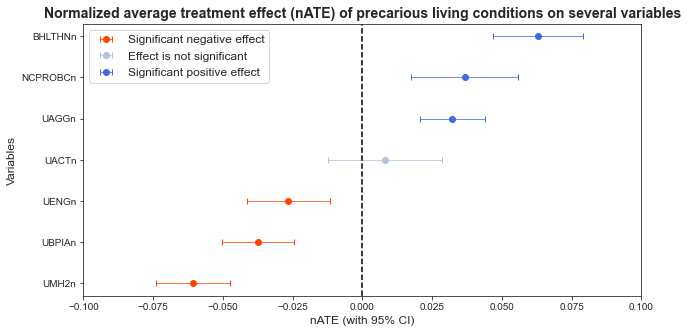

In [75]:
plot_ATE(ate_precarious_fc2,'precarious')

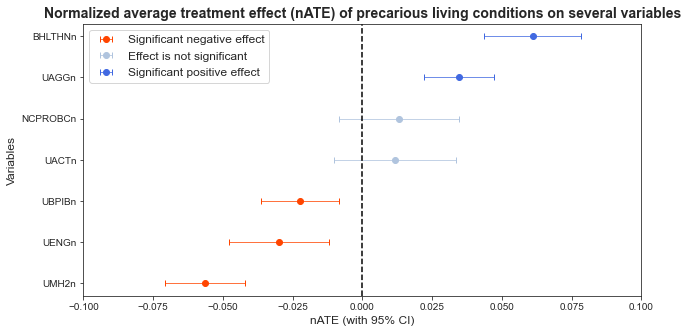

In [76]:
plot_ATE(ate_precarious_fc3,'precarious')

The two figures above show the ATEs for children (top) and teenagers (bottom).  
Let's now look for the difference in ATEs for the 2 subpopulations, in order to see which subgroup is more harshly impacted by precarity and for which outcome variables. We create a new dataframe `age_diff` containing the $\Delta ATE = ATE_{teen}-ATE_{child}$, their CIs and significance. We then reuse our `plot_ATE` method in order to visualize the 95% intervals for the different $\Delta ATE$s.  
Reminder of the CI for the difference between two means (here sample sizes $n_1 \neq n_2$):
$$CI_{\alpha} : (\overline{x_1}-\overline{x_2})\pm Z_{\alpha/2}\cdot SE \rightarrow SE=\sqrt{\frac{(n_1-1)\cdot s_1^2+(n_2-1)\cdot s_2^2}{n_1+n_2-2}}\cdot\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}$$ 

In [77]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
age_diff.variable.iloc[6] ='UBPIn'
ci90s = []
ci95s = []
ci99s = []
# z-values for the 3 CIs
zs = [st.norm.ppf(1-0.1/2), st.norm.ppf(1-0.05/2), st.norm.ppf(1-0.01/2)]
for i in range (0,ate_precarious_fc3.variable.size):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    # sample numbers
    n1=ate_precarious_fc2['Sample size'][i]
    s1=ate_precarious_fc2['Std. Dev'][i]
    n2=ate_precarious_fc3['Sample size'][i]
    s2=ate_precarious_fc3['Std. Dev'][i]
    
    # standard deviation of a difference of samples
    se=np.sqrt(((n1-1)*s1*s1 + (n2-1)*s2*s2)/(n1+n2-2))*np.sqrt(1/n1 + 1/n2)
 
    # ci qui utilise la moitié de la taille de ci que les précédents: 
    ci = [(ate-zs[0]*se,ate+zs[0]*se),(ate-zs[1]*se,ate+zs[1]*se),(ate-zs[2]*se,ate+zs[2]*se)]
    
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'n1, n2'] = '('+str(n1)+' ; '+str(n2)+')'
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

# nice display of confidence intervals
for i in range(3):
    col = ['ci90','ci95','ci99']
    col_fmd = ['90% CI','95% CI','99% CI']
    age_diff.loc[:,col_fmd[i]] = age_diff[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')

In [78]:
age_diff.rename(columns={"ATE": "$\Delta ATE$"})[['variable','n1, n2','$\Delta ATE$','90% CI','95% CI','99% CI','Significance']]

,variable,"n1, n2",$\Delta ATE$,90% CI,95% CI,99% CI,Significance
0,UENGn,(3142 ; 2852),-0.003398,[-0.016810 ; 0.010014],[-0.019379 ; 0.012583],[-0.024401 ; 0.017605],
1,BHLTHNn,(3186 ; 2898),-0.001855,[-0.015685 ; 0.011975],[-0.018334 ; 0.014624],[-0.023512 ; 0.019802],
2,UMH2n,(3188 ; 2878),0.004184,[-0.007407 ; 0.015775],[-0.009627 ; 0.017995],[-0.013967 ; 0.022335],
3,UACTn,(3198 ; 2898),0.003372,[-0.011511 ; 0.018255],[-0.014362 ; 0.021106],[-0.019934 ; 0.026678],
4,UAGGn,(3188 ; 2872),0.002325,[-0.007650 ; 0.012300],[-0.009561 ; 0.014211],[-0.013296 ; 0.017946],
5,NCPROBCn,(3166 ; 2884),-0.023463,[-0.040506 ; -0.006420],[-0.043771 ; -0.003155],[-0.050152 ; 0.003226],**
6,UBPIn,(3176 ; 2884),0.015104,[0.003746 ; 0.026462],[0.001570 ; 0.028637],[-0.002682 ; 0.032890],**


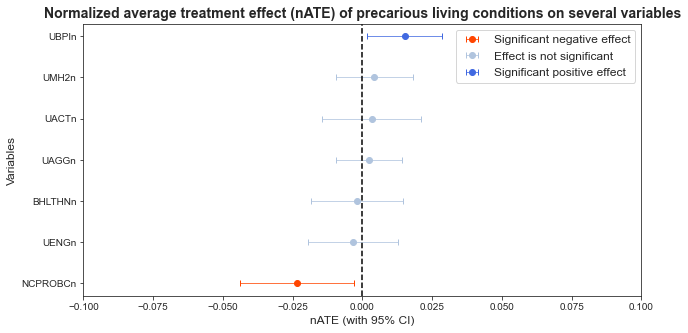

In [79]:
plot_ATE(age_diff,'precarious')

We can see that most variables are not significantly affected by the age group. Note that variables that have a negative $\Delta ATE$ means that their ATE is higher in children than teenagers, and those with a positive $\Delta ATE$ have a higher ATE for teenagers.  
The significant differences are:
- `NCPROBCn`: (depression score) ATE is higher in children: precarious housing impacts children's mental health more negatively than teenagers'.
- `UBPIn`: (behavior score) Teenagers exhibit a higher behavioral score (indicating less problems) compared to children. This means that precarious housing impacts teenagers' behavior less harshly than it does for children.
- `BHLTHNn`: (poor health indicator) Teenagers physical health is more harshly impacted by precarity than children.

We can conclude that overall, mental health and physical health are the only outcome variables that see a significant disparity between the two age groups. Indeed, children (<12 y.o.) have their mental health more harshly affected by precarious conditions than teenagers. On the other hand, teenagers in precarious housing conditions are more affected health-wise than children in the same conditions. There are no significant parental mental health and education discrepencies between the two age groups subpopulations.

---

# Conclusion